In [905]:
%matplotlib inline
%pylab inline
import pandas as pd
from scipy.optimize import minimize
from scipy import signal, optimize

import statsmodels.api as sm
import itertools

from numpy import dot
import warnings
warnings.filterwarnings('ignore')
import numdifftools as ndt

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [906]:
# .Py file with all new functions
import ARMA_Functions as armf

# Start analysis
http://fedc.wiwi.hu-berlin.de/xplore/tutorials/sfehtmlnode63.html

In [1529]:
algorithm = 'SLSQP'

#----------------------------------------
def generateMA(par, sz):
    beta  = par
    eps   = np.random.standard_normal(sz)
    y     = np.repeat(np.mean(eps), sz)
    error = y.copy()
    
    for t in xrange(2,sz):
        error[t] = eps[t] - beta*error[t-1]
        
    return error, eps


def estimateMA(par, data):
    beta   = par
    T      = len(data)
    error  = np.repeat(np.mean(data), T)
    sigma2 = np.var(data)
    
    for t in xrange(2,sz):
        error[t] = data[t] - beta*error[t-1]
        
    sse    = np.sum(error**2.)/(2*sigma2)
    llk    = 0.5 * np.log(2.*np.pi) + 0.5 * log(sigma2) + sse
    
    return llk

#----------------------------------------
def estimateARMA(pars, data):
    beta, theta = pars[0], pars[1]
    T      = len(data)
    error  = np.repeat(np.mean(data), T)
    sigma2 = np.var(data)
    
    for t in xrange(2,T):
        error[t] = data[t] - beta*data[t-1] - theta*error[t-1]
    
    sse    = np.sum(error**2.)/(2*sigma2)
    llk    = 0.5 * np.log(2.*np.pi) + 0.5 * log(sigma2) + sse
    
    return llk


def estimatorARMA(data):
    # Estimate
    bounds = ((0.01, 0.99),(0.01, 0.99))
    x0 = [0.1, 0.1]
    args = (data)
    res = minimize(estimateARMA, x0, args=args, method=algorithm)
    
    return res.x


#----------------------------------------
def profileARMA_beta(pars, data, betaFix, simul=False):
    beta, theta = betaFix, pars[0]
    T      = len(data)
    error  = np.repeat(np.mean(data), T)
    sigma2 = np.var(data)
    
    for t in xrange(2,T):
        error[t] = data[t] - beta*data[t-1] - theta*error[t-1]
    
    sse    = np.sum(error**2.)/(2*sigma2)
    llk    = 0.5 * np.log(2.*np.pi) + 0.5 * log(sigma2) + sse
    
    if simul == False:
        return llk
    else:
        return error


def profileARMA_theta(pars, data, thetaFix, simul=False):
    beta, theta = pars[0], thetaFix
    T      = len(data)
    error  = np.repeat(np.mean(data), T)
    sigma2 = np.var(data)
    
    for t in xrange(2,T):
        error[t] = data[t] - beta*data[t-1] - theta*error[t-1]
    
    sse    = np.sum(error**2.)/(2*sigma2)
    llk    = 0.5 * np.log(2.*np.pi) + 0.5 * log(sigma2) + sse

    if simul == False:
        return llk
    else:
        return error
    
####################
### MAIN FUNC I) ###
####################

def profileARMA_estimator(data, beta=True):
    """ if beta == True --> profile beta
        else: profile theta
        return LLK
    """
    
    # Pre-alocate
    bounds = ((0.01, 0.99))
    x0 = [0.1]
    FUN, PARS = [], []
    parRange = np.linspace(0.1, 0.9, 40) # parameter grid

    # loop: gonna profile beta or theta ?
    if beta == True:
        fun = profileARMA_beta
    else:
        fun = profileARMA_theta
    
    for par in range(len(parRange)):
        args = (data, parRange[par])
        res = minimize(fun, x0, args=args, method=algorithm)
        FUN.append(res.fun)
        PARS.append(res.x)
        
    llk   = pd.DataFrame(np.array(FUN), index=parRange)
    parsH = pd.DataFrame(PARS, index=parRange)
    
    # Max likelihood
    llkOptimal = llk[llk == llk.min()].dropna().index[0]

    # Optimal parameters
    optimalPars = parsH[parsH.index == llkOptimal]
    optimalPars = np.array([optimalPars.index[0], optimalPars[0].values[0]])
    
    return llk, parsH, llkOptimal, optimalPars

#----------------------------------------
# PLOT
#----------------------------------------
def plotProfileLik(a,b,c,d):
    f, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(b, marker='s', alpha=0.5)
    ax.legend([r'$\hat{\eta}$'], fontsize=12, loc='lower left')
    ax.set_ylabel(r'Nuisance parameter value')
    ax.set_xlabel(r'Focal parameter value')
    ax.axhline(d[1], color='b')
    ax2 = plt.twinx()
    (-a).plot(ax=ax2, marker='s', color='r', alpha=0.5)
    ax2.set_ylabel(r'Log-Likelihood')
    ax2.legend([r'$llk$'], fontsize=12, loc='best')
    ax2.axvline(c, color='r')
    plt.tight_layout()
    
    
def plot_McResults(mVec, stdVec):
    f,ax = plt.subplots(1,1,figsize=(6,4))

    c   = ['k','r','b']
    mrk = ['s', 'v', 'o'] 
    for i in range(len(mVec.columns)):
        mVec[mVec.columns[i]].plot(color=c[i], marker=mrk[i])
        (mVec[mVec.columns[i]]-stdVec[stdVec.columns[i]]).plot(color=c[i], linestyle=':')
        (mVec[mVec.columns[i]]+stdVec[stdVec.columns[i]]).plot(color=c[i], linestyle=':')
    plt.ylabel(r'$\sqrt{\chi^2}$', fontsize=22)
    plt.xlabel(r'$Sample$ $size$', fontsize=22)
    ax.legend(['Qml','LpBeta','LpTheta'], fontsize=12, loc='best',
             fancybox=True, framealpha=0.5)
    plt.tight_layout()
    
#----------------------------------------
# BIAS
#----------------------------------------
def estimator_estimateBias(data, truePars, allPars=True):
    """ Aggregated parameter estimation bias -> allPars == True """
    
    pHarQml            = estimatorARMA(data)
    _, _, _, pHatBeta  = profileARMA_estimator(data, beta=True)
    _, _, _, pHatTheta = profileARMA_estimator(data, beta=False)
    
    if allPars == True:
        biasVec = computeBias(pHarQml, pHatBeta, pHatTheta, truePars, allPars=True)
        return biasVec
    else:
        bvecQml, bvecLpBeta, bvecLpTheta = computeBias(pHarQml, pHatBeta, pHatTheta, truePars, allPars=False)
        return bvecQml, bvecLpBeta, bvecLpTheta


def computeBias(pHarQml, pHatBeta, pHatTheta, truePars, allPars=True):
    """ If allPars==True, then we compute the overall bias
        otherwise, we are interested on individual parameter bias (xi - xi^*)
    """
    qmlB = np.abs(np.abs(pHarQml) - np.abs(truePars))
    lpBB = np.abs(np.abs(pHatBeta) - np.abs(truePars))
    lpTB = np.abs(np.abs(pHatTheta) - np.abs(truePars[::-1])) # USE [::-1] just like SOE!
    
    if allPars == True:
        sum1 = np.sum(qmlB)
        DF = pd.DataFrame(np.array([sum1]), columns=['qmlBias'])
        DF['LpBetaBias'] = np.sum(lpBB)
        DF['LpThetaBias'] = np.sum(lpTB)

        return DF
    else:
        return qmlB, lpBB, lpTB
    
#----------------------------------------
# Monte-Carlo
#----------------------------------------
def MonteCarloBias(truePars, sz, MC=30):
    """ Use for single iteration """
    
    RES = pd.DataFrame()
    # Simulate and estimate
    for mc in range(MC):
        sdata, _ = armf.generateArma(truePars, sz)
        biasVec  = estimator_estimateBias(sdata, truePars, allPars=True)
        RES      = pd.concat([RES, biasVec], axis=0)
        
    return RES


def MonteCarloBias_fullIteration(pars, MC=30):
    # For 100, 150, 200, 250 ... 1000, compute 30 Monte-Carlo simulations per sample
    MeanVec = pd.DataFrame(); StdVec = MeanVec.copy()
    sampleGrid = np.linspace(100, 1000, 20).astype(int) # sample sizes to obtain estimates
    
    for sz in sampleGrid:
        print(sz)
        RES = MonteCarloBias(pars, sz, MC=MC)
        MeanVec = pd.concat([MeanVec, pd.DataFrame(RES.mean()).T], axis=0)
        StdVec = pd.concat([StdVec, pd.DataFrame(RES.std()).T], axis=0)
    
    # Add index
    MeanVec.index = sampleGrid; StdVec.index = sampleGrid
    
    return MeanVec, StdVec

# ARMA

array([ 0.31975204,  0.55025066])

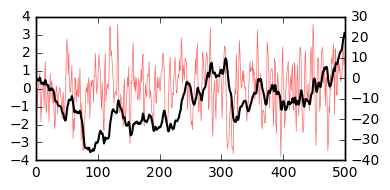

In [1297]:
par = [0.3, 0.5]
sz = 500

# Simulate
sdata, eps = armf.generateArma(par,sz)
f,ax = plt.subplots(1,1,figsize=(4,2))
plt.plot(sdata, linewidth=0.5, color='r', alpha=0.6)
ax = plt.twinx()
ax.plot(np.cumsum(sdata), linewidth=1.5, color='k')
plt.tight_layout()

# Estimate
estimatorARMA(sdata)

# ARMA Lprofile

## Beta and Theta

----
beta|eta
----
Min. LLK function 0.346
optimal parameter combination [ 0.34615385  0.49684868]
True Pars [0.3, 0.5]
----
theta|eta
----
Min. LLK function 0.490
optimal parameter combination [ 0.48974359  0.34969261]
True Pars [0.3, 0.5]


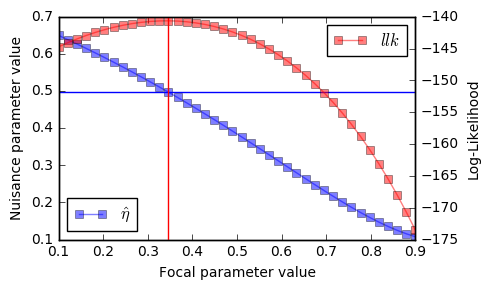

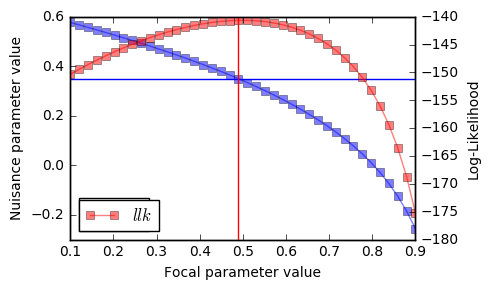

In [1287]:
print('----')
print('beta|eta')
print('----')
a, b, c, d = profileARMA_estimator(sdata, beta=True)
print('Min. LLK function %.3f'%c)
print('optimal parameter combination %s'%d)
print('True Pars %s'%par)
# Plot
plotProfileLik(a,b,c,d)

print('----')
print('theta|eta')
print('----')
aa, bb, cc, dd = profileARMA_estimator(sdata, beta=False)
print('Min. LLK function %.3f'%cc)
print('optimal parameter combination %s'%dd)
print('True Pars %s'%par)
# Plot
plotProfileLik(aa,bb,cc,dd)

# Compare estimation performance of three methods

In [1280]:
estimator_estimateBias(sdata, par, allPars=True)

,qmlBias,LpBetaBias,LpThetaBias
0,0.043056,0.049305,0.059949


## Monte-Carlo estimation

In [1281]:
RES = MonteCarloBias(par, 100, MC=30)

In [1282]:
# Qml, LpBeta, LpTheta
print('MEAN ---> %s'%RES.mean().values)
print('STD  ---> %s'%RES.std().values)

MEAN ---> [ 0.18481177  0.18018482  0.18512761]
STD  ---> [ 0.14056528  0.13281063  0.13548058]


# Over several samples

In [1259]:
%time mVec, stdVec = MonteCarloBias_fullIteration(par, MC=100)

100
147
194
242
289
336
384
431
478
526
573
621
668
715
763
810
857
905
952
1000
CPU times: user 25min 51s, sys: 7.67 s, total: 25min 59s
Wall time: 26min 2s


red -> LpBeta and blue -> LpTheta


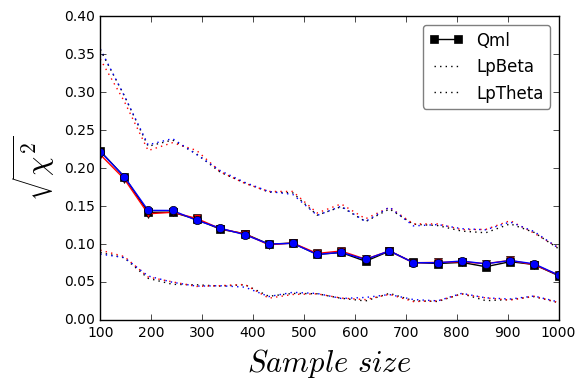

In [1232]:
plot_McResults(mVec, stdVec)
print('red -> LpBeta and blue -> LpTheta; results using SLSQP')


# Modified Profile Likelihood

In [ ]:
#--------------------------------------------------------------
def getHandScores(pars, data, parFix, beta=True):
    H      = calculate_hessianMatrix(pars, data, parFix, beta=beta)
    scores = calc_scoresLprofile(pars, data, parFix, beta=beta)
    return H, scores


def calculate_hessianMatrix(pars, data, parFix, beta=True):
    if beta==True:
        f = lambda x: profileARMA_beta(x, data, parFix)
    else:
        f = lambda x: profileARMA_theta(x, data, parFix)
    
    # Get Hessian
    Hfun = ndt.Hessian(f, full_output=False, method='central')
    if beta == True:
        H = Hfun(pars[-1])
    else:
        H = Hfun(pars[0])
    FIM = mat(inv(H))
        
    return FIM


def getFisherInfoMatrixFullARMAModel(data, pars):
    f = lambda x: estimateARMA(x, sdata)
    Hfun = ndt.Hessian(f, full_output=False, method='central')
    H = Hfun(pars)
    FIM = mat(inv(-H))
    return FIM


def calc_scoresLprofile(pars, data, parFix, beta=True):

    ## Sensitivity analysis
    step = 1e-5 * np.array(pars)
    T = np.size(data, 0)
    scores = np.zeros((T,len(pars)))

    for i in xrange(len(pars)):
        h = step[i]
        delta = np.zeros(len(pars))
        delta[i] = h
        if beta == True:
            logliksplus = profileARMA_beta(pars[0] + delta,
                                           data, parFix, simul=True)
            loglikminus = profileARMA_beta(pars[0] - delta,
                                           data, parFix, simul=True)
            scores[:,i] = (logliksplus - loglikminus)/(2*h)
        else:
            logliksplus = profileARMA_theta(pars[1] + delta,
                                           data, parFix, simul=True)
            loglikminus = profileARMA_theta(pars[1] - delta,
                                           data, parFix, simul=True)
            scores[:,i] = (logliksplus - loglikminus)/(2*h)
            
    covMatrix = np.dot(scores.T, scores)
    covMatrix = covMatrix[0][0]**-1.

    return covMatrix


def estimate_mpl_beta(data):
    # first, Lp
    _, _, _, parsHatLp = profileARMA_estimator(data, beta=True)
    
    # Compute Scores and FIM
    FIM, scores = getHandScores(parsHatLp, sdata, parsHatLp[-1], beta=True)
    
    # Pre-alocate
    bounds = ((0.01, 0.99))
    x0 = [0.1]
    FUN, PARS = [], []
    parRange = np.linspace(0.1, 0.9, 40) # parameter grid

    # loop: gonna profile beta or theta ?
    fun = profileARMA_mod_beta
    
    for par in range(len(parRange)):
        args = (data, parRange[par], scores, False)
        res = minimize(fun, x0, args=args, method=algorithm)
        FUN.append(res.fun)
        PARS.append(res.x)
    
    llk   = pd.DataFrame(np.array(FUN), index=parRange)
    parsH = pd.DataFrame(PARS, index=parRange)
    
    # Max likelihood
    llkOptimal = llk[llk == llk.min()].dropna().index[0]

    # Optimal parameters
    optimalPars = parsH[parsH.index == llkOptimal]
    optimalPars = np.array([optimalPars.index[0], optimalPars[0].values[0]])
    
    return llk, parsH, llkOptimal, optimalPars


#----------------------------------------
def profileARMA_mod_beta(pars, data, betaFix, X_hat, simul=False):
    beta, theta = betaFix, pars[0]
    T           = len(data)
    error       = np.repeat(np.mean(data), T)
    sigma2      = np.var(data)
    
    for t in xrange(2,T):
        error[t] = data[t] - beta*data[t-1] - theta*error[t-1]
        
    # Pre-calculations
    pars_step         = np.array([betaFix, pars[-1]])
    Fish_step, X_step = getHandScores(pars_step, data, betaFix, beta=True)
    detI = np.array([np.abs(np.linalg.det(Fish_step))])
    detS = np.array([np.abs(np.dot(X_hat.T, X_step))])
    
    sse = np.sum(error**2.)/(2*sigma2)
    llk = 0.5 * np.log(2.*np.pi) + 0.5 * log(sigma2) + sse
    #llm = llk - detI - detS # ISSUE IS IN THIS COMPUTATION OS detI and detS
    llm = llk * detI**(-1/2.)
    
    if simul == False:
        return llm
    else:
        return error

In [ ]:
sdata, eps = generateArma(pars, 1000)

# MPL
%time a,b,c,d = estimate_mpl_beta(sdata)
# LP
aa, bb, cc, dd = profileARMA_estimator(sdata, beta=True)

In [ ]:
(-a).plot()
ax = plt.twinx()
print('True pars %s'%pars )
print('----')
print(d)
(-aa).plot(ax=ax)
print(dd)
plt.tight_layout()
[plt.axvline(pars[i]) for i in range(1)]
plt.tight_layout()